In [1]:
import sys
import os
current_dir = os.path.abspath('')  # 获取当前目录的绝对路径
parent_dir = os.path.dirname(current_dir)  # 获取父目录
sys.path.append(parent_dir + '\\scripts')

print("Current directory:", current_dir)
print("Parent directory:", parent_dir)

%load_ext autoreload
%aimport source, vis, pinn, dde_param, dataset
%autoreload 1
%aimport

import source, vis, pinn, dde_param

Current directory: d:\Git\PINN-LiDAR\sample
Parent directory: d:\Git\PINN-LiDAR


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Modules to reload:
dataset dde_param pinn source vis

Modules to skip:



In [2]:
# acoustic_deeponet.py
import numpy as np
import deepxde as dde
import torch
import matplotlib.pyplot as plt
from source import create_source
from vis import Avis
from dde_param import AcousticDeepONet


In [3]:
# I intend to use the acoustic deeponet to predict the sound field
# The acoustic deeponet is a deep learning model that can be used to predict the sound field in a given environment. It is based on the deep operator network (DeepONet) architecture, which is a type of neural network that can be used to approximate operators. The acoustic deeponet is trained on a dataset of sound field measurements, and it can then be used to predict the sound field in new environments.
# The innovative point is, I want to operate it in the spacial fourier space, so that my network can be more efficient and faster.
# the equation list bellow

*** equation of fourier er space for acoustic deepONet ***

- fourier transfer of spacial sound pressure
       p(x, t) = ∫∫∫ p(k, t) * exp(-i * k * x) dk
- fourier transfer of spacial sound pressure gradient
       ∇p(x, t) = ∫∫∫ p(k, t) * (-i * k) * exp(-i * k * x) dk

- descrete form of the wave number k in spherical coordinates (r, θ, φ)
      k = 2 * π * f / c * (sin(θ) * cos(φ), sin(θ) * sin(φ), cos(θ))

- in deep operator, it can be written as::
    p(x, t) = ∑∑∑ p(k, t) * exp(-i * k * x) * dk
    ∇p(x, t) = ∑∑∑ p(k, t) * (-i * k) * exp(-i * k * x) * dk
    where dk = 2 * π * f / c * (sin(θ) * cos(φ), sin(θ) * sin(φ), cos(θ)) * dθ * dφ * dr
    and r = 2 * π * f / c * r

- to train the operator, we have
       ∇p(x, t) = F(p(x, t)) = ∑∑∑ p(k, t) * (-i * k) * exp(-i * k * x) * dk
       where F is the operator, p(x, t) is the input, and ∇p(x, t) is the output.
       The goal is to learn the operator F such that it can predict the output ∇p(x, t) given the input p(x, t). This can be done by training the operator using a dataset of input-output pairs (p(x, t), ∇p(x, t)).

### The structure of the DeepONet

- It's aim to train the network seprately, the branch network aim to capture the general information which is the mapping principle of the function in Banach space, however the Trunk provide the associate positional informatioin to make sure the rest of the information can be exptracted to there.

- Question, Can we impose a rule to the Branch network to force it convergence? which might cause a shorter training time.

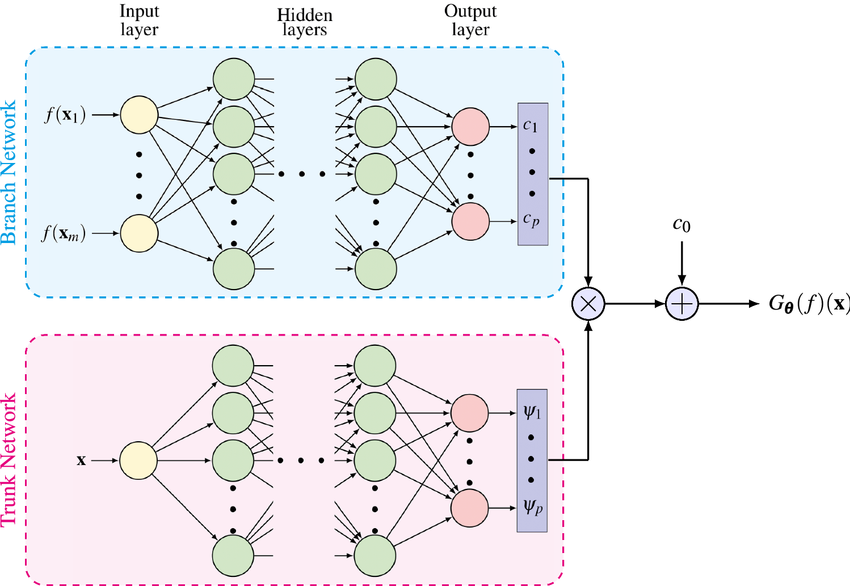

In [7]:
from dataset import Dataset
# Instantiate the Dataset
source = ...  # Your source instance
n_sensors = 8
dataset = Dataset(source=source, n_sensors=n_sensors)

# Grid parameters
grid_params = {
    'grid_size': 256,
    'x_range': (-5, 5),
    'y_range': (-5, 5)
}

# Generate data using the standard method and grid sampling
bigXb, bigXt, bigY = dataset.gen(
    method='standard',
    sampling='random',
    grid_params=grid_params,
)
print("Generated dataset with standard method and grid sampling.")
print("Sensor Data (bigXb):", bigXb[:5])
print("Evaluation Points (bigXt):", bigXt[:5])
print("Field Pressure Data (bigY):", bigY[:5])

AttributeError: 'ellipsis' object has no attribute 'update_params'

In [ ]:
stop here

In [ ]:
ns = 36        # sampling number
n_train=1500  # 训练样本数
n_test=300    # 测试样本数
grid_points=ns #

# 1) 创建并初始化
sim = AcousticDeepONet(n_sensors=ns)
sim.setup_source('spherical', freq=300, radius=0.15)

# 2) 生成训练+测试数据
print("\nGenerating training dataset...")
# Generate the training dataset with specified parameters
Xb_train, Xt_train, y_train = sim.generate_dataset(
    n_samples=n_train,      # Number of training samples
    grid_points=grid_points, # Number of grid points, equal to the number of sensors
    seed=123                # Random seed for data reproducibility
)
print("Train set shapes:", Xb_train.shape, Xt_train.shape, y_train.shape)

print("\nGenerating testing dataset...")
Xb_test, Xt_test, y_test = sim.generate_dataset(n_samples=n_test, grid_points=grid_points, seed=456)
print("Test set shapes:", Xb_test.shape, Xt_test.shape, y_test.shape)

# 3) 生成 DeepXDE 的数据容器
print("\nConstructing DeepXDE's data container...")
# 存储数据，如果没有特殊设置，将数据放到默认的temp文件，文件中的内容提前销毁
data = dde.data.Triple(
    X_train=(Xb_train, Xt_train),
    y_train=y_train,
    X_test=(Xb_test, Xt_test),
    y_test=y_test,
)
#存储
sim.save_data(data)


Test set shapes: (388800, 110) (388800, 2) (388800, 1)


In [ ]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:

# 3) 构造 DeepXDE 的数据容器
data = dde.data.Triple(
    X_train=(Xb_train, Xt_train),
    y_train=y_train,
    X_test=(Xb_test, Xt_test),
    y_test=y_test,
)

# 4) 一次性训练
model, losshistory, train_state = sim.train(
    data,
    n_train=n_train,  # 训练样本数
    n_test=n_test,    # 测试样本数
    grid_points=grid_points,
    epochs=800,
    display_every=100
)


In [ ]:

# 5) 绘制 loss 曲线
plt.figure()
plt.plot(losshistory.steps, losshistory.loss_train, label="Train Loss")
plt.plot(losshistory.steps, losshistory.loss_test, label="Test Loss")
plt.yscale("log")
plt.xscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Testing Loss")
plt.legend()
plt.show()

In [ ]:
# freq = sim.branch_vec[0]
# radius = sim.branch_vec[1]

# # 只取后面和传感器相关的部分: 
# # 从 index=2 开始，到 2 + 3*n_sensors结束，包含 (x1, y1, p1, x2, y2, p2, ...)
# sensor_data = sim.branch_vec[2 : 2 + 3*sim.n_sensors]

# # 先 reshape 成 (n_sensors, 3)，让每一行对应 (x_i, y_i, p_i)
# sensor_data = sensor_data.reshape(sim.n_sensors, 3)

# # 其中前两列就是 (x_i, y_i)
# sensor_locs = sensor_data[:, 0:2]  # shape = (n_sensors, 2)

# # 如果还需要传感器测量值 p_i，取第三列
# sensor_pressures = sensor_data[:, 2]  # shape = (n_sensors,)

In [ ]:

# 2) 一次性训练
model, losshistory, train_state = sim.train(
    n_train=1500,  # 训练样本数
    n_test=300,    # 测试样本数
    grid_points=ns,
    epochs=10,
    display_every=100
)

model.restore('para_m/final-800.pt')



Current parameters:
c: 343

Current parameters:
omega: 762.3680687716447

Current parameters:
k: 2.2226474308211217

Current parameters:
freq: 121.33464660042927

Current parameters:
radius: 0.12994312172450978
Test set shapes: (388800, 110) (388800, 2) (388800, 1)
Compiling model...
'compile' took 0.000356 s


Start training with epochs=10, display_every=100 ...
Training model...

Step      Train loss    Test loss     Test metric
0         [9.06e+12]    [9.48e+12]    []  
10        [9.06e+12]    [9.48e+12]    []  

Best model at step 0:
  train loss: 9.06e+12
  test loss: 9.48e+12
  test metric: []

Epoch 10: saving model to para_m/final-10.pt ...

'train' took 3.592260 s



C:\Users\1ieng\AppData\Roaming\Python\Python312\site-packages\deepxde\model.py:1130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)



Current parameters:
c: 343

Current parameters:
omega: 3141.592653589793

Current parameters:
k: 9.159162255363828

Current parameters:
freq: 500

Current parameters:
radius: 0.3

Generating heat map for SphericalSource
Current parameters: {'c': 343, 'omega': 3141.592653589793, 'k': 9.159162255363828, 'freq': 500, 'radius': 0.3}

Generating heat map for PredictSource
Current parameters: {'c': 343, 'omega': 3141.592653589793, 'k': 9.159162255363828, 'freq': 500, 'radius': 0.3}


d:\Git\PINN-LiDAR\scripts\dde_param.py:246: ComplexWarning: Casting complex values to real discards the imaginary part
  branch_vec = np.array(branch_vec, dtype=np.float32)
d:\Git\PINN-LiDAR\scripts\vis.py:142: ComplexWarning: Casting complex values to real discards the imaginary part
  full_pressure[mask] = pressure


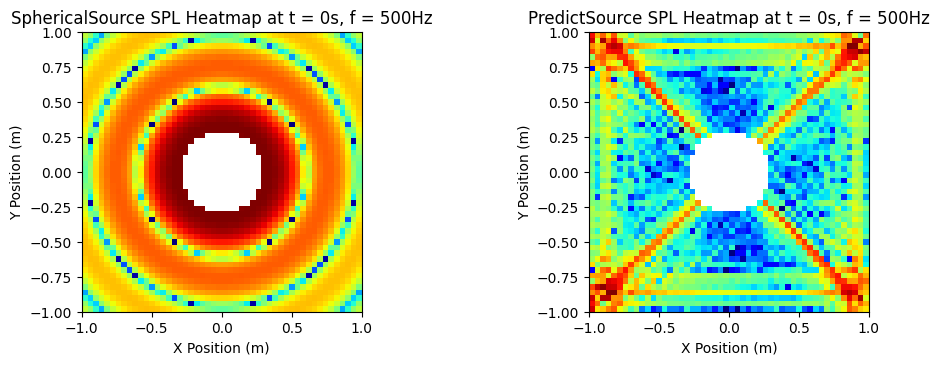

In [ ]:


grid_size = 50

grid_params = {
    'grid_size': grid_size,
    'x_range': (-1, 1),
    'y_range': (-1, 1)
}

# 先预测
Xg, Yg, pred_field = sim.predict_field(model, freq=500, radius=0.3, grid_size=grid_size)

pred_field = np.abs(np.fft.ifft2(np.fft.ifftshift(pred_field)))
        # 用DummySource包装预测结果以使用Avis
class PredictSource:
    def __init__(self, pressure, source_params):
        self.pressure = pressure
        self.freq = source_params['freq']
        self.params = source_params.copy()
    def compute_pressure(self, **kwargs):
        return self.pressure

dummy_source = PredictSource(pred_field, sim.source.params)

# 再计算真实场
coords = np.column_stack((Xg.flatten(), Yg.flatten(), np.zeros(Xg.size)))

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
Avis.create_heat_map(sim.source, grid_params, t = 0, db_range = (-60, 0))

# plt.scatter(sensor_locs[:, 0], sensor_locs[:, 1], 
#             c='red', marker='x', s=100)
plt.subplot(2,2,2)
Avis.create_heat_map(dummy_source, grid_params, t = 0, db_range = (-60, 0))
plt.show()




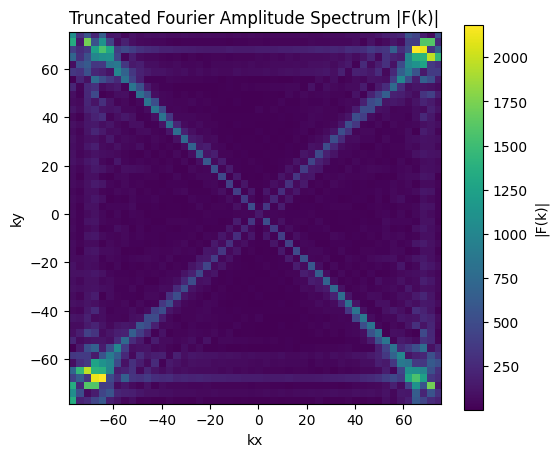

In [ ]:
from matplotlib import cm

# Domain and grid setup
L = 2
N = 50

grid_params = {
    'grid_size': N,
    'x_range': (-L/2, L/2),
    'y_range': (-L/2, L/2)
}

dk = 2 * np.pi / L
kx = np.fft.fftshift(np.fft.fftfreq(N, d=(L/N))) * 2 * np.pi
ky = np.fft.fftshift(np.fft.fftfreq(N, d=(L/N))) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)

# Plot the truncated Fourier amplitude spectrum
plt.figure(figsize=(6, 5))
plt.imshow((np.abs(pred_field)), extent=[kx[0], kx[-1], ky[0], ky[-1]], origin='lower', cmap=cm.viridis)
plt.title("Truncated Fourier Amplitude Spectrum |F(k)|")
plt.xlabel("kx")
plt.ylabel("ky")
plt.colorbar(label='|F(k)|')
plt.show()


Generating heat map for SphericalSource
Current parameters: {'c': 343, 'omega': 3141.592653589793, 'k': 9.159162255363828, 'freq': 500, 'radius': 0.3}


array([[0.01078588, 0.01038823, 0.00996049, ..., 0.00996049, 0.01038823,
        0.01078588],
       [0.01038823, 0.0099587 , 0.00949991, ..., 0.00949991, 0.0099587 ,
        0.01038823],
       [0.00996049, 0.00949991, 0.00901098, ..., 0.00901098, 0.00949991,
        0.00996049],
       ...,
       [0.00996049, 0.00949991, 0.00901098, ..., 0.00901098, 0.00949991,
        0.00996049],
       [0.01038823, 0.0099587 , 0.00949991, ..., 0.00949991, 0.0099587 ,
        0.01038823],
       [0.01078588, 0.01038823, 0.00996049, ..., 0.00996049, 0.01038823,
        0.01078588]])

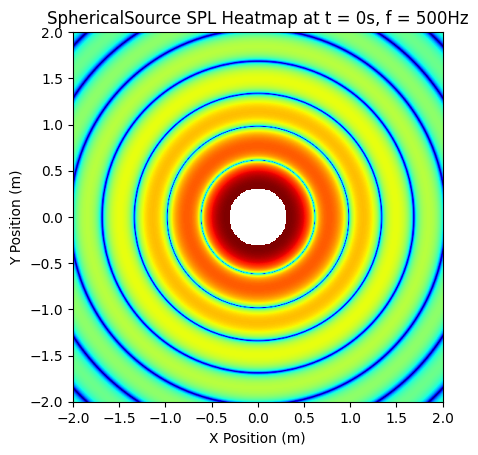

In [ ]:


grid_params = {
    'grid_size': 500,
    'x_range': (-2, 2),
    'y_range': (-2, 2)
}
Avis.create_heat_map(sim.source, grid_params, t = 0, db_range = (-60, 0))